
# **Seguidor Solar — Modo Manual (2 GDL)**
**Incluye:**
- Ingreso de **fecha** y **horas** por el usuario (sin valores quemados).
- Cálculo de **azimut/elevación** (NOAA) y conversión a **roll/pitch**.
- **Gráficas 2D** (elevación, azimut, pitch, roll).
- Animación **HTML con controles** (play/pausa) que **se guarda** en la carpeta de salida.
- **Apartado MANUAL**: mueve el **Sol con el mouse** (polar) y el panel se reorienta; **fallback** con **sliders**.


In [67]:

# === Backend interactivo robusto ===
import sys, subprocess, importlib

def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        except Exception:
            pass

BACKEND_OK = False
try:
    _ensure("ipympl"); _ensure("ipywidgets")
    get_ipython().run_line_magic("matplotlib", "widget")
    BACKEND_OK = True
except Exception:
    try:
        get_ipython().run_line_magic("matplotlib", "notebook")
        BACKEND_OK = True
    except Exception:
        BACKEND_OK = False

import matplotlib
print("Backend interactivo listo:", BACKEND_OK, "| backend =", matplotlib.get_backend())


Backend interactivo listo: True | backend = widget


In [68]:

from __future__ import annotations
import numpy as np
import pandas as pd
from math import sin, cos, tan, atan2, asin, acos, radians, degrees, hypot
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from IPython.display import HTML, display

# Zona horaria y carpeta de salida (ajustada a Windows)
TZ = ZoneInfo("America/Guayaquil")
OUTDIR = Path(r"C:/Users/Matthew/Desktop/Metodos/SeguidorSolar/salidas")
OUTDIR.mkdir(parents=True, exist_ok=True)
print("OUTDIR:", OUTDIR)


OUTDIR: C:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas


## Posición solar (NOAA compacta)

In [69]:

def solar_position_noaa(dt_local, lat, lon):
    if dt_local.tzinfo is None:
        raise ValueError("dt_local debe ser tz-aware")
    dt_utc = dt_local.astimezone(ZoneInfo("UTC"))
    y, m = dt_utc.year, dt_utc.month
    d = dt_utc.day + (dt_utc.hour + dt_utc.minute/60 + dt_utc.second/3600)/24
    if m <= 2:
        y -= 1; m += 12
    A = int(y/100); B = 2 - A + int(A/4)
    JD = int(365.25*(y+4716)) + int(30.6001*(m+1)) + d + B - 1524.5
    T = (JD - 2451545.0) / 36525.0

    L0 = (280.46646 + 36000.76983*T + 0.0003032*T*T) % 360
    M  = 357.52911 + 35999.05029*T - 0.0001537*T*T
    e  = 0.016708634 - 0.000042037*T - 0.0000001267*T*T
    Mr = radians(M)
    C  = (1.914602 - 0.004817*T - 0.000014*T*T)*sin(Mr) + (0.019993 - 0.000101*T)*sin(2*Mr) + 0.000289*sin(3*Mr)
    true_long = L0 + C
    omega = 125.04 - 1934.136*T
    lamb = true_long - 0.00569 - 0.00478*sin(radians(omega))

    eps0 = 23 + (26 + ((21.448 - T*(46.815 + T*(0.00059 - 0.001813*T))))/60)/60
    eps = eps0 + 0.00256*cos(radians(omega))
    epsr = radians(eps)
    lambdar = radians(lamb)

    delta = asin(sin(epsr)*sin(lambdar))

    y_e = tan(epsr/2); y_e *= y_e
    EoT = 4*(degrees(y_e*sin(2*radians(L0)) - 2*e*sin(Mr) + 4*e*y_e*sin(Mr)*cos(2*radians(L0)) - 0.5*y_e*y_e*sin(4*radians(L0)) - 1.25*e*e*sin(2*Mr)))

    time_offset = EoT + 4*lon
    tst = ((dt_local.hour*60 + dt_local.minute + dt_local.second/60) + time_offset) % 1440
    HRA = radians((tst/4) - 180)

    latr = radians(lat)
    cos_zen = sin(latr)*sin(delta) + cos(latr)*cos(delta)*cos(HRA)
    cos_zen = max(-1.0, min(1.0, cos_zen))
    zen = acos(cos_zen)
    elevation = 90 - degrees(zen)

    az_south_ccw = degrees(atan2(sin(HRA), cos(HRA)*sin(latr) - tan(delta)*cos(latr)))
    az_north_cw = (az_south_ccw + 180) % 360
    return az_north_cw, elevation


## Geometría: vectores y ángulos del panel

In [70]:

def solar_vector_ENU(az_deg, el_deg):
    az = radians(az_deg); el = radians(el_deg)
    E = cos(el)*sin(az); N = cos(el)*cos(az); U = sin(el)
    return np.array([E,N,U], float)

def solar_to_panel_angles(az_deg, el_deg):
    if el_deg <= 0:
        return None, None
    az = radians(az_deg); el = radians(el_deg)
    E = cos(el)*sin(az); N = cos(el)*cos(az); U = sin(el)
    roll  = degrees(atan2(E, U))
    pitch = degrees(atan2(-N, hypot(E,U)))
    return roll, pitch

def panel_normal_from_angles(roll_deg, pitch_deg):
    pr = radians(roll_deg); pp = radians(pitch_deg)
    nx =  sin(pr)*cos(pp)
    ny =  sin(pp)
    nz =  cos(pr)*cos(pp)
    return np.array([nx,ny,nz], float)

def panel_quad_vertices(n, size=0.8, thickness=0.03):
    n = n/np.linalg.norm(n)
    ref = np.array([0,0,1.0])
    u = np.cross(n, ref)
    if np.linalg.norm(u) < 1e-6:
        ref = np.array([1.0,0,0])
        u = np.cross(n, ref)
    u = u/np.linalg.norm(u)
    v = np.cross(n, u)
    a = size*0.5
    front = np.array([
        -a*u - a*v + (thickness/2.0)*n,
         a*u - a*v + (thickness/2.0)*n,
         a*u + a*v + (thickness/2.0)*n,
        -a*u + a*v + (thickness/2.0)*n,
    ])
    back = front - thickness*n
    return front, back


## Simulación por intervalo

In [71]:

def simular_intervalo(fecha_str, hora_inicio, hora_fin, lat, lon, paso_min=10, tz=TZ):
    t0 = datetime.strptime(f"{fecha_str} {hora_inicio}", "%Y-%m-%d %H:%M").replace(tzinfo=tz)
    t1 = datetime.strptime(f"{fecha_str} {hora_fin}", "%Y-%m-%d %H:%M").replace(tzinfo=tz)
    if t1 <= t0:
        raise ValueError("hora_fin debe ser > hora_inicio")
    ts, azs, els, rolls, pitchs = [], [], [], [], []
    t = t0
    while t <= t1:
        az, el = solar_position_noaa(t, lat, lon)
        r, p = solar_to_panel_angles(az, el)
        ts.append(t); azs.append(az); els.append(el); rolls.append(r); pitchs.append(p)
        t += timedelta(minutes=paso_min)
    df = pd.DataFrame({
        "datetime_local": ts,
        "azimuth_deg": azs,
        "elevation_deg": els,
        "roll_deg": rolls,
        "pitch_deg": pitchs,
    })
    return df


## Gráficas 2D

In [72]:

def graficas_2d(df, fecha_label=""):
    dfx = df.dropna(subset=["pitch_deg", "roll_deg"])
    plt.figure(); plt.plot(df["datetime_local"], df["elevation_deg"], color="orange"); plt.title(f"Elevación — {fecha_label}"); plt.xlabel("Hora"); plt.ylabel("Elevación (°)"); plt.grid(True)
    plt.figure(); plt.plot(df["datetime_local"], df["azimuth_deg"],  color="blue");   plt.title(f"Azimut — {fecha_label}");    plt.xlabel("Hora"); plt.ylabel("Azimut (°)");    plt.grid(True)
    plt.figure(); plt.plot(dfx["datetime_local"], dfx["pitch_deg"],  color="green");  plt.title(f"Pitch — {fecha_label}");     plt.xlabel("Hora"); plt.ylabel("Pitch (°)");     plt.grid(True)
    plt.figure(); plt.plot(dfx["datetime_local"], dfx["roll_deg"],   color="red");    plt.title(f"Roll — {fecha_label}");      plt.xlabel("Hora"); plt.ylabel("Roll (°)");      plt.grid(True)
    plt.show()


## Animación HTML con controles (se guarda en OUTDIR)

In [73]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from IPython.display import HTML, display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def animar_3d_html(df: pd.DataFrame, nombre_base: str, max_seg=30, fps=12):
    dfx = df.dropna(subset=["pitch_deg", "roll_deg"]).reset_index(drop=True)
    if len(dfx) == 0:
        print("No hay muestras diurnas para animar.")
        return None
    frames = min(len(dfx), max_seg*fps)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("Este (E)"); ax.set_ylabel("Norte (N)"); ax.set_zlabel("Arriba (U)")
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1); ax.set_zlim(0, 1.0)
    ax.view_init(elev=22, azim=-60)
    plt.tight_layout()

    # Suelo
    suelo = np.array([[-1,-1,0],[ 1,-1,0],[ 1, 1,0],[-1, 1,0]])
    ax.add_collection3d(Poly3DCollection([suelo], alpha=0.15, facecolor='gray'))

    # Panel inicial
    n0 = panel_normal_from_angles(dfx.loc[0,"roll_deg"], dfx.loc[0,"pitch_deg"])
    front, back = panel_quad_vertices(n0, size=0.8, thickness=0.03)
    panel_poly = Poly3DCollection([front, back], alpha=0.85, facecolor='#1f77b4')
    ax.add_collection3d(panel_poly)
    marco = Line3DCollection([np.vstack([front, front[0]])], colors='#0d3b66', linewidths=2.0)
    ax.add_collection3d(marco)

    # Normal del panel
    n_hat = n0/np.linalg.norm(n0)
    normal_quiv = ax.quiver(0,0,0.25, n_hat[0]*0.4, n_hat[1]*0.4, n_hat[2]*0.4, color='green', linewidth=2)

    # Sol inicial (punto + flecha ÚNICA)
    sv0 = solar_vector_ENU(dfx.loc[0,"azimuth_deg"], dfx.loc[0,"elevation_deg"])
    sun_point = ax.scatter([sv0[0]],[sv0[1]],[sv0[2]], marker='o', c='gold', s=220,
                           edgecolors='orange', linewidths=1.5)
    sun_quiv  = ax.quiver(0,0,0, sv0[0],sv0[1],sv0[2], length=1.0, normalize=True, color='gold')

    def update(i):
        nonlocal normal_quiv, sun_quiv

        # Panel
        r = float(dfx.loc[i,"roll_deg"]); p = float(dfx.loc[i,"pitch_deg"])
        n = panel_normal_from_angles(r, p)
        f, b = panel_quad_vertices(n, size=0.8, thickness=0.03)
        panel_poly.set_verts([f, b])
        marco.set_segments([np.vstack([f, f[0]])])

        # Normal
        try:
            normal_quiv.remove()
        except Exception:
            pass
        n_hat = n/np.linalg.norm(n)
        normal_quiv = ax.quiver(0,0,0.25, n_hat[0]*0.4, n_hat[1]*0.4, n_hat[2]*0.4,
                                color='green', linewidth=2)

        # Sol (punto + flecha ÚNICA)
        sv = solar_vector_ENU(dfx.loc[i,"azimuth_deg"], dfx.loc[i,"elevation_deg"])
        sun_point._offsets3d = (np.array([sv[0]]), np.array([sv[1]]), np.array([sv[2]]))
        try:
            sun_quiv.remove()
        except Exception:
            pass
        sun_quiv = ax.quiver(0,0,0, sv[0],sv[1],sv[2], length=1.0, normalize=True, color='gold')

        ax.set_title(dfx.loc[i,"datetime_local"].strftime("Hora local: %H:%M"))
        return panel_poly, marco, normal_quiv, sun_point, sun_quiv

    ani = FuncAnimation(fig, update, frames=frames, interval=int(1000/max(fps,1)))
    html = ani.to_jshtml(fps=fps, default_mode="loop")
    display(HTML(html))

    out_path = OUTDIR / f"{nombre_base}.html"
    out_path.write_text(html, encoding="utf-8")
    plt.close(fig)
    print("HTML guardado en:", out_path)
    return out_path


## Apartado MANUAL — Mueve el Sol con el mouse (polar)

In [74]:
# === REEMPLAZA COMPLETA tu función (arregla que NO rote el 3D; solo se mueve el Sol) ===
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

def colocar_sol_con_mouse(init_az: float = 150.0, init_el: float = 25.0):
    """
    Control manual con mouse:
      - Arrastra el punto dorado en el gráfico 2D (Az vs El) para mover el Sol.
      - El panel se reorienta automáticamente.
      - El eje 3D queda BLOQUEADO (no rota ni se desplaza con el mouse).
    """

    # -------- helpers --------
    def _clamp(v, a, b): return max(a, min(b, v))

    def _sv_to_angles(sv):
        # Convierte vector solar ENU -> (roll, pitch) usando la convención del proyecto
        sx, sy, sz = sv
        pitch = -np.degrees(np.arcsin(np.clip(sy, -1.0, 1.0)))
        roll  =  np.degrees(np.arctan2(sx, max(sz, 1e-12)))
        return roll, pitch

    def _apuntar_panel_a_sol(az_deg, el_deg):
        nonlocal sun_point, sun_quiv, normal_quiv

        sv = solar_vector_ENU(az_deg, el_deg)

        # actualizar sol (punto + flecha ÚNICA)
        sun_point._offsets3d = ([sv[0]], [sv[1]], [sv[2]])
        try: sun_quiv.remove()
        except Exception: pass
        sun_quiv = ax.quiver(0,0,0, sv[0],sv[1],sv[2], length=1.0, normalize=True, color='gold')

        # orientar panel
        r, p = _sv_to_angles(sv)
        n = panel_normal_from_angles(r, p)
        f, b = panel_quad_vertices(n, size=0.8, thickness=0.03)
        panel_poly.set_verts([f, b])
        marco.set_segments([np.vstack([f, f[0]])])

        try: normal_quiv.remove()
        except Exception: pass
        nh = n/(np.linalg.norm(n)+1e-12)
        normal_quiv = ax.quiver(0,0,0.25, nh[0]*0.4, nh[1]*0.4, nh[2]*0.4, color='green', linewidth=2)

        ax.set_title(f"Manual — Az: {az_deg:.1f}°, El: {el_deg:.1f}°  |  "
                     f"Roll: {r:.1f}°, Pitch: {p:.1f}°")
        fig.canvas.draw_idle()

    # -------- escena 3D (BLOQUEADA) --------
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("Este (E)"); ax.set_ylabel("Norte (N)"); ax.set_zlabel("Arriba (U)")
    ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(0,1.0)
    ax.view_init(elev=22, azim=-60)
    plt.tight_layout()

    # 🔒 Desactiva interacción del 3D para que NO rote/panee con el mouse
    try:
        ax.mouse_init(rotate_btn=None, zoom_btn=None)  # Axes3D: desactiva rotar/zoom
    except Exception:
        pass
    try:
        ax.set_navigate(False)  # bloquea navegación del eje
    except Exception:
        pass
    try:
        # (si existe) oculta la toolbar interactiva
        fig.canvas.toolbar_visible = False
    except Exception:
        pass

    # Suelo
    suelo = np.array([[-1,-1,0],[1,-1,0],[1,1,0],[-1,1,0]])
    ax.add_collection3d(Poly3DCollection([suelo], alpha=0.15, facecolor='gray'))

    # Panel inicial mirando al sol inicial
    sv0 = solar_vector_ENU(init_az, init_el)
    r0, p0 = _sv_to_angles(sv0)
    n0 = panel_normal_from_angles(r0, p0)
    front, back = panel_quad_vertices(n0, size=0.8, thickness=0.03)
    panel_poly = Poly3DCollection([front, back], alpha=0.85, facecolor='#1f77b4')
    ax.add_collection3d(panel_poly)
    marco = Line3DCollection([np.vstack([front, front[0]])], colors='#0d3b66', linewidths=2.0)
    ax.add_collection3d(marco)

    nh0 = n0/(np.linalg.norm(n0)+1e-12)
    normal_quiv = ax.quiver(0,0,0.25, nh0[0]*0.4, nh0[1]*0.4, nh0[2]*0.4, color='green', linewidth=2)

    sun_point = ax.scatter([sv0[0]],[sv0[1]],[sv0[2]], marker='o', c='gold', s=220,
                           edgecolors='orange', linewidths=1.5)
    sun_quiv  = ax.quiver(0,0,0, sv0[0],sv0[1],sv0[2], length=1.0, normalize=True, color='gold')

    ax.set_title(f"Manual — Az: {init_az:.1f}°, El: {init_el:.1f}°  |  "
                 f"Roll: {r0:.1f}°, Pitch: {p0:.1f}°")
    plt.show(block=False)

    # -------- lienzo 2D de control (solo aquí se captura el drag) --------
    fig2d, ax2d = plt.subplots(figsize=(5,3))
    ax2d.set_xlim(0,360); ax2d.set_ylim(0,90)
    ax2d.set_xlabel("Azimut (°)"); ax2d.set_ylabel("Elevación (°)")
    ax2d.grid(True, alpha=0.3)
    p2d, = ax2d.plot([init_az], [init_el], 'o', color='gold', markersize=8)
    ax2d.set_title(f"Coloca el Sol — Az: {init_az:.1f}°, El: {init_el:.1f}°")

    state = {"drag": False, "az": init_az, "el": init_el}

    def on_press(event):
        if event.inaxes != ax2d: 
            return
        state["drag"] = True

    def on_release(event):
        state["drag"] = False

    def on_move(event):
        if (not state["drag"]) or (event.inaxes != ax2d):
            return
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        state["az"] = x % 360.0
        state["el"] = _clamp(y, 0.0, 90.0)

        # actualiza punto 2D
        p2d.set_data([state["az"]], [state["el"]])
        ax2d.set_title(f"Coloca el Sol — Az: {state['az']:.1f}°, El: {state['el']:.1f}°")
        fig2d.canvas.draw_idle()

        # apunta panel/sol en 3D
        _apuntar_panel_a_sol(state["az"], state["el"])

    cid1 = fig2d.canvas.mpl_connect("button_press_event", on_press)
    cid2 = fig2d.canvas.mpl_connect("button_release_event", on_release)
    cid3 = fig2d.canvas.mpl_connect("motion_notify_event", on_move)

    plt.show()


## (Fallback) Control manual con Sliders

In [75]:

import ipywidgets as widgets
from IPython.display import display

def control_manual_sliders(az0=150.0, el0=25.0):
    az_slider = widgets.FloatSlider(value=az0, min=0, max=359, step=1, description='Azimut (°)')
    el_slider = widgets.FloatSlider(value=el0, min=0, max=90, step=1, description='Elevación (°)')

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("Este (E)"); ax.set_ylabel("Norte (N)"); ax.set_zlabel("Arriba (U)")
    ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(0,1); ax.view_init(elev=22, azim=-60)
    suelo = np.array([[-1,-1,0],[1,-1,0],[1,1,0],[-1,1,0]])
    ax.add_collection3d(Poly3DCollection([suelo], alpha=0.15, facecolor='gray'))

    r0,p0 = solar_to_panel_angles(az0, el0)
    n0 = panel_normal_from_angles(r0, p0)
    front, back = panel_quad_vertices(n0, size=0.8, thickness=0.03)
    panel_poly = Poly3DCollection([front, back], alpha=0.85, facecolor='#1f77b4')
    ax.add_collection3d(panel_poly)
    marco = Line3DCollection([np.vstack([front, front[0]])], colors='#0d3b66', linewidths=2.0)
    ax.add_collection3d(marco)
    n_hat0 = n0/np.linalg.norm(n0)
    normal_quiv = ax.quiver(0,0,0.25, n_hat0[0]*0.4, n_hat0[1]*0.4, n_hat0[2]*0.4, color='green', linewidth=2)

    sv0 = solar_vector_ENU(az0, el0)
    sun_point = ax.scatter([sv0[0]],[sv0[1]],[sv0[2]], marker='o', c='gold', s=220, edgecolors='orange', linewidths=1.5)
    sun_quiv  = ax.quiver(0,0,0, sv0[0],sv0[1],sv0[2], length=1.0, normalize=True, color='gold')

    def on_change(_):
        nonlocal normal_quiv, sun_quiv
        az, el = az_slider.value, el_slider.value
        r,p = solar_to_panel_angles(az, el)
        n = panel_normal_from_angles(r, p)
        f,b = panel_quad_vertices(n, size=0.8, thickness=0.03)
        panel_poly.set_verts([f,b]); marco.set_segments([np.vstack([f,f[0]])])

        try: normal_quiv.remove()
        except Exception: pass
        n_hat = n/np.linalg.norm(n)
        normal_quiv = ax.quiver(0,0,0.25, n_hat[0]*0.4, n_hat[1]*0.4, n_hat[2]*0.4, color='green', linewidth=2)

        sv = solar_vector_ENU(az, el)
        sun_point._offsets3d = (np.array([sv[0]]), np.array([sv[1]]), np.array([sv[2]]))
        try: sun_quiv.remove()
        except Exception: pass
        sun_quiv = ax.quiver(0,0,0, sv[0],sv[1],sv[2], length=1.0, normalize=True, color='gold')
        ax.set_title(f"Sol: az={az:.1f}°, el={el:.1f}°  |  Panel: roll={r:.1f}°, pitch={p:.1f}°")
        fig.canvas.draw_idle()

    az_slider.observe(on_change, names='value')
    el_slider.observe(on_change, names='value')
    display(az_slider, el_slider)
    on_change(None)


## Ejecución: simular día, guardar CSV + HTML y abrir MODO MANUAL

CSV guardado en: C:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas\sim_2025-08-10.csv


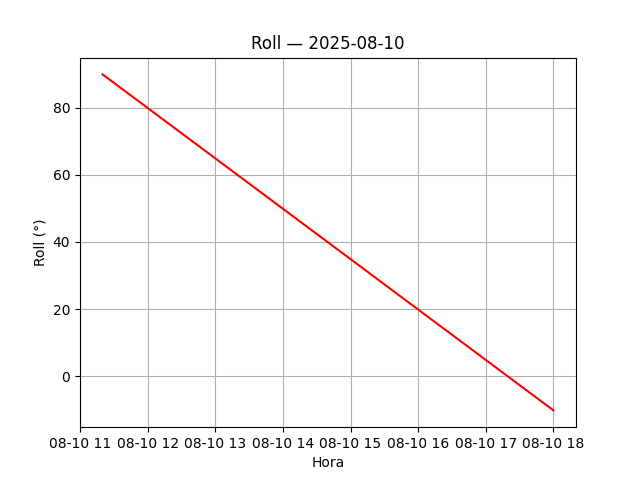

HTML guardado en: C:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas\anim_seguidor_2025-08-10.html
HTML: C:\Users\Matthew\Desktop\Metodos\SeguidorSolar\salidas\anim_seguidor_2025-08-10.html


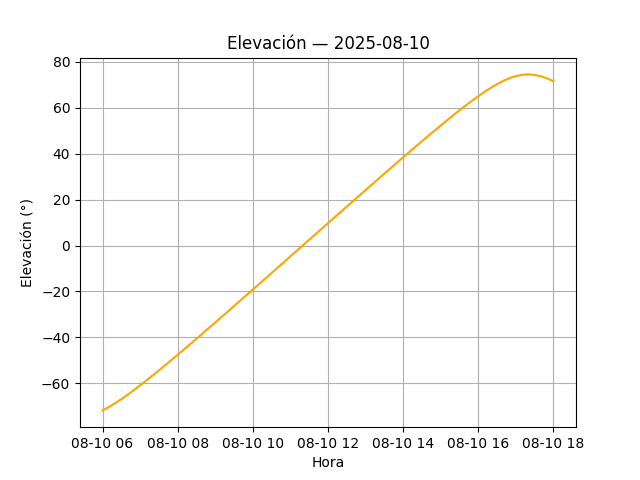

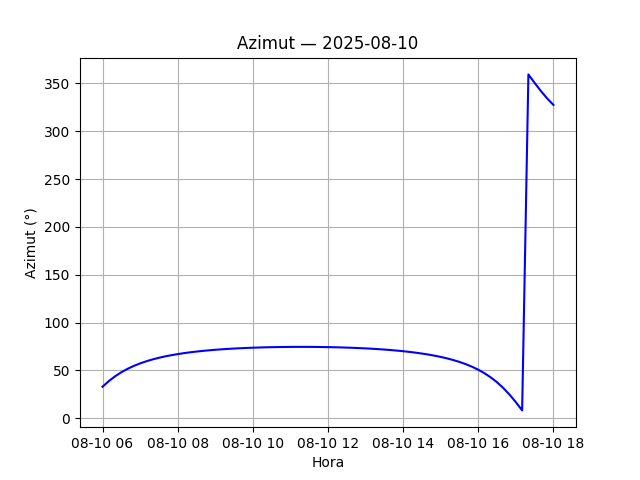

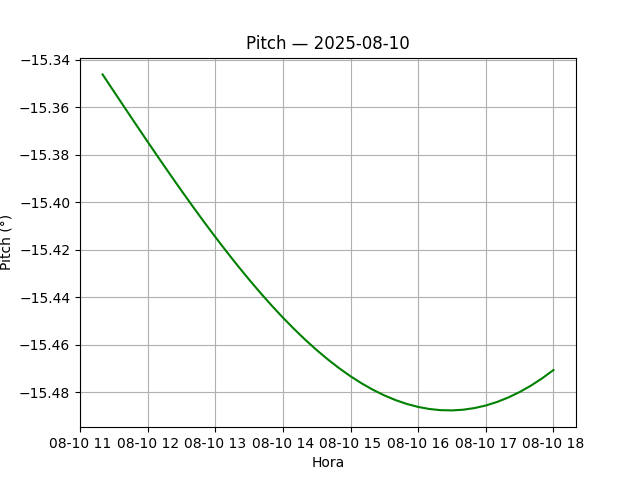

In [76]:

# Entrada del usuario
fecha_str = input("Fecha (YYYY-MM-DD) [Enter = hoy]: ").strip()
hora_ini  = input("Hora inicio (HH:MM) [Enter=06:00]: ").strip()
hora_fin  = input("Hora fin (HH:MM) [Enter=18:00]: ").strip()

from datetime import datetime as _dt
if not fecha_str:
    fecha_str = _dt.now(TZ).strftime("%Y-%m-%d")
if not hora_ini:
    hora_ini = "06:00"
if not hora_fin:
    hora_fin = "18:00"

LAT_EPN, LON_EPN = -0.2105367, -78.491614

# Simular
df = simular_intervalo(
    fecha_str=fecha_str, hora_inicio=hora_ini, hora_fin=hora_fin,
    lat=LAT_EPN, lon=LON_EPN, paso_min=10, tz=TZ
)

# Guardar CSV
csv_path = OUTDIR / f"sim_{fecha_str}.csv"
df.to_csv(csv_path, index=False)
print("CSV guardado en:", csv_path)

# Gráficas
graficas_2d(df, fecha_label=fecha_str)

# Animación HTML con controles (guardada en OUTDIR)
html_path = animar_3d_html(df, nombre_base=f"anim_seguidor_{fecha_str}", max_seg=20, fps=12)
print("HTML:", html_path)


### Lanzar apartado MANUAL

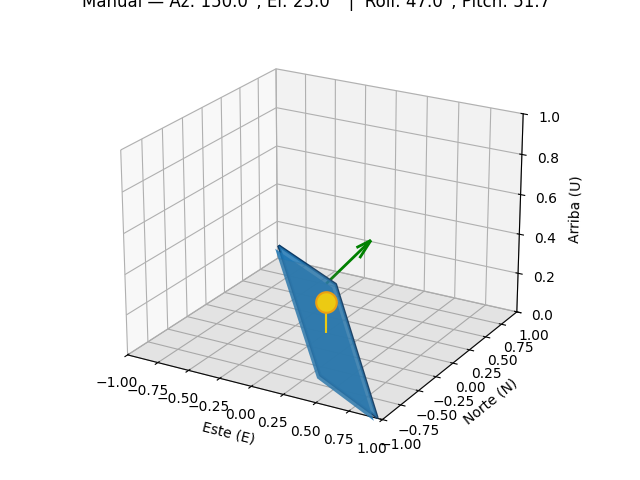

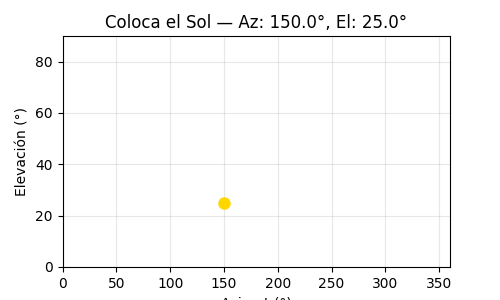

In [77]:

if BACKEND_OK:
    colocar_sol_con_mouse(init_az=150.0, init_el=25.0)
else:
    print("Backend interactivo no disponible. Abriendo fallback con sliders.")
    control_manual_sliders(az0=150.0, el0=25.0)
